In [1]:
import math
import json
import sympy as sp
from sympy.utilities.lambdify import lambdify
import numpy as np
import matplotlib.pyplot as plt

import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe

from vehicle_lib.vehicle_lib import *


In [2]:
# load track data
with open("track_data/simple_track.json", "r") as read_file:
    track_data = json.load(read_file)


# Kinematic bicycle model

The dynamic system equations are given by

$
\dot X
=
f(x,y,\psi)
=
\begin{pmatrix} 
  \dot x \\
  \dot y \\
  \dot \psi
\end{pmatrix}
=
\begin{pmatrix} 
  v \cos( \delta + \psi) \\
  v \sin( \delta + \psi) \\
  v / l_r \sin( \delta ), \\
\end{pmatrix}
$

with the state vector

$ X = [ x, y, \psi ]^T $.


Herein, $x$ and $y$ denote the coordinates of the vehicle front axle in cartesian space and $\psi$ the vehicle body orientation angle. The system inputs are the steering angle $\delta$ and the vehicle velocity $v$. Finally, the parameter $l_r$ denotes the wheelbase, which is the length in-between front and rear axle.




In [3]:
x, y, v, delta, psi, l_r, T_s, n = sp.symbols('x y v delta psi l_r T_s n')

x_dot   = v * sp.cos( delta + psi )
y_dot   = v * sp.sin( delta + psi )
psi_dot = v / l_r * sp.sin( delta )

# system function f
f = sp.Matrix([ x_dot, y_dot, psi_dot ])

# state vector
X_bic = sp.Matrix( [ x, y, psi ])

# input vector
U_bic = sp.Matrix( [ delta, v ])

In [4]:
f

Matrix([
[v*cos(delta + psi)],
[v*sin(delta + psi)],
[  v*sin(delta)/l_r]])

# Discretization of the continunous model

By applying Euler-forward discretization

$ {X}[k+1] = \underbrace{ {X}[k] + T_s  \dot{X} }_{f_{dscr}} $,

the continuous system is time-discretized with the sampling time $T_s$ yielding the discrete system funtion $f_{dscr}$.


In [5]:
# apply Euler forward
f_dscr = sp.Matrix( [x,y,psi]) + T_s * f

In [6]:
f_dscr

Matrix([
[T_s*v*cos(delta + psi) + x],
[T_s*v*sin(delta + psi) + y],
[T_s*v*sin(delta)/l_r + psi]])

# Analytically compute the Jacobian matrices

A linearization of the non-linear system function around a dynamic set point is calculated by deriving the jacobian matrices w.r.t. the state vector $X$ and each system input $\delta$ and $v$:

continuous case 
$
  A = \frac{ \partial f }{ \partial X},
  \qquad
  B = \frac{ \partial f }{ \partial [ \delta, v ]^T },  
$

discrete-time case
$
  A_{dscr} = \frac{ \partial f_{dscr} }{ \partial X},
  \qquad
  B_{dscr} = \frac{ \partial f_{dscr} }{ \partial [ \delta, v ]^T },  
$

In [7]:
# continuous system matrices
A = f.jacobian(X_bic)
B = f.jacobian(U_bic)

# discrete system matrices
A_dscr = f_dscr.jacobian(X_bic)
B_dscr = f_dscr.jacobian(U_bic)

In [8]:
A_dscr

Matrix([
[1, 0, -T_s*v*sin(delta + psi)],
[0, 1,  T_s*v*cos(delta + psi)],
[0, 0,                       1]])

In [9]:
B_dscr

Matrix([
[-T_s*v*sin(delta + psi), T_s*cos(delta + psi)],
[ T_s*v*cos(delta + psi), T_s*sin(delta + psi)],
[   T_s*v*cos(delta)/l_r,   T_s*sin(delta)/l_r]])

# Create functions that generate the matrices A, B, and the system function f

Create python functions with which the symbolically dervied matrices and system function can be evaluated. 

In [10]:
variables = (T_s,l_r, x,y,psi,v,delta)

array2mat = [{'ImmutableDenseMatrix': np.matrix}, 'numpy']

A_dscr_fn = lambdify( variables, A_dscr, modules=array2mat)
B_dscr_fn = lambdify( variables, B_dscr, modules=array2mat)
f_dscr_fn = lambdify( variables, f_dscr, modules=array2mat)


In [11]:
A_dscr_fn(0.01, 3.0, 0.1,0.2,0.4,10,0.1)

matrix([[ 1.        ,  0.        , -0.04794255],
        [ 0.        ,  1.        ,  0.08775826],
        [ 0.        ,  0.        ,  1.        ]])

In [12]:
B_dscr_fn(0.01, 3.0, 0.1,0.2,0.4,10,0.1)

matrix([[-0.04794255,  0.00877583],
        [ 0.08775826,  0.00479426],
        [ 0.03316681,  0.00033278]])

In [13]:
f_dscr_fn(0.01, 3.0, 0.1,0.2,0.4,10,0.1)

matrix([[0.18775826],
        [0.24794255],
        [0.40332778]])

# Run a simulation to generate test data

Set-up a simulation of a vehicle (bicycle model). The vehicle is controlled to follow a given path. In addition, an intended lateral distance $\Delta l$ is modulated by applying a pre-defined profile to the reference $\Delta l_r$. 

In [14]:
system = dy.enter_system()

velocity               = dy.system_input( dy.DataTypeFloat64(1), name='velocity_',  default_value=23.75,  value_range=[0, 25],   title="vehicle velocity")
Delta_l_r              = dy.system_input( dy.DataTypeFloat64(1), name='Delta_l_r',  default_value=0.0,    value_range=[-10, 10], title="lateral deviation to the path")


# parameters
wheelbase = 3.0

# sampling time
Ts = 0.01

# create storage for the reference path:
path = import_path_data(track_data)

# create placeholders for the plant output signals
x   = dy.signal()
y   = dy.signal()
psi = dy.signal()


def path_following_controller( path, x, y, psi, velocity, Delta_l_r = 0.0, k_p=2.0, Ts=0.01  ):
    """
        Steering control for path tracking 
    
        Controlls a kinematic bicycle model (assumption) to follow the given path.
        Herein, the steering angle delta is the control variable. The variables
        x, y, psi, and velocity are measurements taken from the controlled system.
        The lateral offset Delta_l_r to the path is the reference.
    """


    results = {}
    

    # track the evolution of the closest point on the path to the vehicles position
    d_star, x_r, y_r, psi_rr, K_r, Delta_l, tracked_index, Delta_index = track_projection_on_path(path, x, y)

    #
    # project the vehicle velocity onto the path yielding v_star 
    #
    # Used formula inside project_velocity_on_path:
    #   v_star = d d_star / dt = v * cos( Delta_u ) / ( 1 - Delta_l * K(d_star) ) 
    #

    Delta_u = dy.signal() # feedback from control
    v_star = project_velocity_on_path(velocity, Delta_u, Delta_l, K_r)


    #
    # compute an enhanced (less noise) signal for the path orientation psi_r by integrating the 
    # curvature profile and fusing the result with psi_rr to mitigate the integration drift.
    #

    psi_r, psi_r_dot = compute_path_orientation_from_curvature( Ts, v_star, psi_rr, K_r, L=1.0 )
    
    # feedback control
    u = dy.PID_controller(r=Delta_l_r, y=Delta_l, Ts=Ts, kp=k_p)

    # path tracking
    # resulting lateral model u --> Delta_l : 1/s
    Delta_u << dy.asin( dy.saturate(u / velocity, -0.99, 0.99) )
    delta = dy.unwrap_angle(angle=psi_r - psi + Delta_u, normalize_around_zero = True)

    
    
    # collect resulting signals
    results['x_r']       = x_r
    results['y_r']       = y_r
    results['v_star']    = v_star
    results['d_star']    = d_star
    results['psi_r']     = psi_r
    results['psi_r_dot'] = psi_r_dot
    results['Delta_l_r'] = Delta_l_r    
    results['Delta_l']   = Delta_l
    results['Delta_u']   = Delta_u
    results['delta']     = delta

    return results





results = path_following_controller( path, x, y, psi, velocity, Delta_l_r=dy.rate_limit(Delta_l_r, Ts, -0.8, 0.8)   )




#
# The model of the vehicle including a disturbance
#

# steering angle limit
limited_steering = dy.saturate(u=results['delta'], lower_limit=-math.pi/2.0, upper_limit=math.pi/2.0)

# the model of the vehicle
x_, y_, psi_, x_dot, y_dot, psi_dot = discrete_time_bicycle_model(limited_steering, velocity, Ts, wheelbase)

# close the feedback loops
x << x_
y << y_
psi << psi_



#
# outputs: these are available for visualization in the html set-up
#

dy.append_primay_ouput(x, 'x')
dy.append_primay_ouput(y, 'y')
dy.append_primay_ouput(psi, 'psi')
dy.append_primay_ouput(psi_dot, 'psi_dot')

dy.append_primay_ouput(results['delta'], 'delta')

dy.append_primay_ouput(results['x_r'], 'x_r')
dy.append_primay_ouput(results['y_r'], 'y_r')
dy.append_primay_ouput(results['psi_r'], 'psi_r')

dy.append_primay_ouput(results['Delta_l'], 'Delta_l')

dy.append_primay_ouput(results['d_star'], 'd_star')
dy.append_primay_ouput(velocity*dy.float64(1.0), 'velocity')


# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.TargetWasm(enable_tracing=False), folder="generated/tmp1", build=True)

#
dy.clear()


compiling system Subsystem1000 (level 1)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
compiling system simulation (level 0)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
Generated code will be written to generated/tmp1 .
Running compiler: emcc --bind -s MODULARIZE=1 -s EXPORT_NAME="ORTD_simulator" generated/tmp1/main.cpp -g4 -s -o generated/tmp1/main.js
Compilation result:  32512


In [15]:
compiled_system = dyexe.CompiledCode(code_gen_results)

# define a profile for the lateral distance

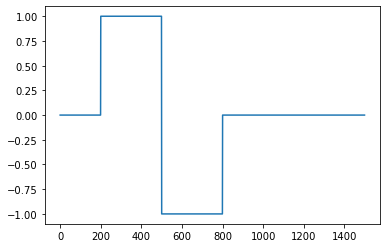

In [16]:
Delta_l_r_profile = np.concatenate((  np.zeros(200), np.ones(300), -np.ones(300),  np.zeros(700) ))


plt.figure()
plt.plot(Delta_l_r_profile)
plt.show()


Run the simulation given parameters to define the steering rates


In [17]:
testsim = dyexe.SystemInstance(compiled_system)

N=1500
input_data = {'velocity_': 5.0, 'Delta_l_r': Delta_l_r_profile }

# sim_results = run_batch_simulation(testsim, input_data, N )
# sim_results = dyexe.run_batch_simulation(testsim, input_data, N,  output_keys=['x', 'y', 'psi', 'psi_dot', 'steering', 'velocity'] )
sim_results = dyexe.run_batch_simulation(testsim, input_data, N,  output_keys=['x', 'y', 'x_r', 'y_r', 'psi', 'psi_dot', 'velocity'] )


In [18]:
# sim_results

# Add noise to the model (sensing noise)

Simulate measurement noise which is, e.g., introduced by GPS.

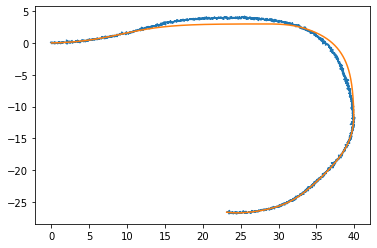

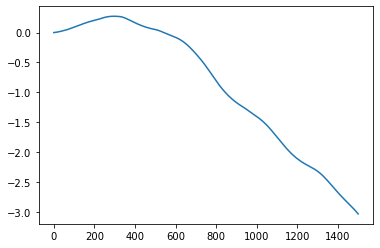

In [19]:
# X/Y positioning noise (normal distribution)
eta_x = np.random.normal(0, 0.1, N)
eta_y = np.random.normal(0, 0.1, N)

x_meas = eta_x + sim_results['x']
y_meas = eta_y + sim_results['y']
psi_meas = sim_results['psi']
psi_dot_meas = sim_results['psi_dot']
v_meas = sim_results['velocity']

plt.figure()
plt.plot(x_meas, y_meas)
plt.plot(sim_results['x_r'], sim_results['y_r'])
plt.show()

plt.figure()
plt.plot(psi_meas)
plt.show()

# Extended Kalman filter

The extended Kalman filter is applied to the linearized model descibed by the matrices $A_{dscr}$ and $B_{dscr}$ and given the system function $f_{dscr}$. The simulated data serves as measured data and is the input to the filter.

In [20]:
f_dscr

Matrix([
[T_s*v*cos(delta + psi) + x],
[T_s*v*sin(delta + psi) + y],
[T_s*v*sin(delta)/l_r + psi]])

In [21]:
A_dscr

Matrix([
[1, 0, -T_s*v*sin(delta + psi)],
[0, 1,  T_s*v*cos(delta + psi)],
[0, 0,                       1]])

In [22]:
B_dscr

Matrix([
[-T_s*v*sin(delta + psi), T_s*cos(delta + psi)],
[ T_s*v*cos(delta + psi), T_s*sin(delta + psi)],
[   T_s*v*cos(delta)/l_r,   T_s*sin(delta)/l_r]])

The implemented filter in form of a loop

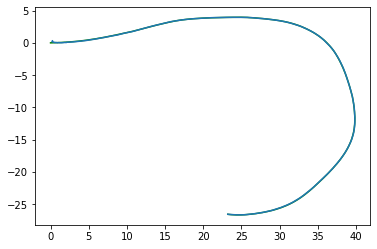

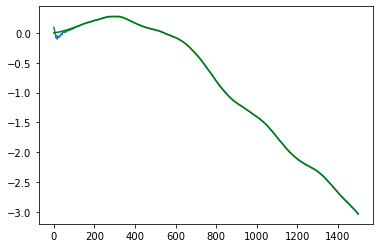

In [23]:
l_r = wheelbase

# allocate space to store the filter results
results = {'delta' : np.zeros(N), 'x' : np.zeros(N), 'y' : np.zeros(N), 'psi' : np.zeros(N) }

# the guess/estimate of the initial states
X = np.matrix([ [0.5], [0.5], [0.1] ])

P = np.matrix([  [0.1, 0,   0     ], 
                 [0,   0.1, 0     ],
                 [0,   0,   0.1   ]  ])

# covariance of the noise w addtitive to the states
Q = 0.00001*np.matrix([  [1, 0, 0 ], 
                         [0, 1, 0 ],
                         [0, 0, 1 ]  ])
 
# covariance of the noise v in the measured system output signal
R = np.matrix([  [0.1, 0   ], 
                 [0  , 0.1 ]  ])


for i in range(0,N):
    
    # measured input signals 
    v       = v_meas[i]
    x       = x_meas[i]
    y       = y_meas[i]
    psi_dot = psi_dot_meas[i]
    
    
    # compute steering angle by the inverse for the vehicle orientation change 
    delta = math.asin( psi_dot * l_r / v )
        
    # system output vector (x, y)
    z = np.matrix([ [x], [y] ])
    
    # pridiction step using the non-linear model (f_dscr) 
    # x(k-1|k-1) --> x(k|k-1)
    
    X[0] = X[0] + Ts * ( v * math.cos( X[2] + delta ) )
    X[1] = X[1] + Ts * ( v * math.sin( X[2] + delta ) )
    X[2] = X[2] + Ts * ( v / l_r * math.sin(delta) )
    
    # optionally use the auto-generated python function for evaluation
    # X = f_dscr_fn( Ts, l_r, float(X[0]), float(X[1]), float(X[2]), v, delta )

    # evaluate jacobi matrices A_dscr and B_dscr
    F = np.matrix([  [1, 0, -Ts*v*math.sin(delta+X[2])  ], 
                     [0, 1,  Ts*v*math.cos(delta+X[2])  ],
                     [0, 0, 1                           ]   ])
    
    # optionally use the auto-generated python function for evaluation
    # F = A_dscr_fn( Ts, l_r, float(X[0]), float(X[1]), float(X[2]), v, delta )
    
    
    B = np.matrix([  [-Ts*v*math.sin(delta+X[2]), Ts*math.cos(delta+X[2])      ], 
                     [ Ts*v*math.cos(delta+X[2]), Ts*math.sin(delta+X[2])      ],
                     [Ts*v/l_r * math.cos(delta), Ts/l_r * math.sin(delta)     ]   ])
    
    # optionally use the auto-generated python function for evaluation
    # B = B_dscr_fn( Ts, l_r, float(X[0]), float(X[1]), float(X[2]), v, delta )
    
    # the system output matrix: returns X and Y when multiplied with the state vector X
    # which are compared to the measurements
    H = np.matrix([  [1,0,0], 
                     [0,1,0] ])
    
    # prdicted state covariance P(k|k-1)
    P = F*P*F.transpose() + Q
    
    # estimation output residual vector
    e = z - H*X
        
    # Kalman gain
    S = H*P*H.transpose() + R
    K = P*H.transpose() * np.linalg.inv( S )
    
    # post priori state X(k|k)
    X = X + K*e
    
    # post priori covariance
    P = (np.eye(3) - K*H) * P

    
    
    # store results
    results['delta'][i] = delta
    results['x'][i] = X[0]
    results['y'][i] = X[1]
    results['psi'][i] = X[2]
    

# show results
plt.figure()
#plt.plot(x_meas, y_meas, '+')
plt.plot(sim_results['x'], sim_results['y'], 'g')
plt.plot(results['x'], results['y'])
plt.show()

plt.figure()
plt.plot(results['psi'])
plt.plot(sim_results['psi'], 'g')
plt.show()